In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
N_POINTS = 300
LATENT_DIM = 50 
BATCH_SIZE = 32
EPOCHS = 6000
SAMPLE_INTERVAL = 500
PLOT_ROWS = 6
PLOT_COLS = 2

In [10]:
def prepare_data(n_samples):
    X = torch.linspace(-5, 5, N_POINTS).to(device)
    base_y = 2 * torch.sin(torch.exp(X*0.5)/(X*0.5 - 4))
    base_samples = torch.stack((X, base_y), dim=1)
    samples = base_samples.unsqueeze(0).repeat(n_samples, 1, 1)
    noise = torch.randn(n_samples, N_POINTS, device=device) * 0.1
    samples[:, :, 1] += noise
    
    return samples

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),

            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, N_POINTS * 2),
            nn.Unflatten(1, (N_POINTS, 2)))
    
    def forward(self, z):
        return self.model(z)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(N_POINTS * 2, 512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            
            nn.Linear(128, 1),
            nn.Sigmoid())
    
    def forward(self, seq):
        return self.model(seq)

In [13]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0008, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()
plot_data = []

for epoch in range(EPOCHS):
    real_data = prepare_data(BATCH_SIZE)
    real_labels = torch.ones(BATCH_SIZE, 1, device=device)

    z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
    fake_data = generator(z)
    fake_labels = torch.zeros(BATCH_SIZE, 1, device=device)
    
    discriminator.zero_grad()
    
    real_output = discriminator(real_data)
    d_loss_real = criterion(real_output, real_labels)
    
    fake_output = discriminator(fake_data.detach())
    d_loss_fake = criterion(fake_output, fake_labels)
    
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_D.step()
    
    generator.zero_grad()
    fake_output = discriminator(fake_data)
    g_loss = criterion(fake_output, real_labels)
    g_loss.backward()
    optimizer_G.step()
    
    if epoch % 250 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
    
    if epoch % SAMPLE_INTERVAL == 0:
        generator.eval()
        with torch.no_grad():
            test_z = torch.randn(1, LATENT_DIM, device=device)
            generated = generator(test_z).cpu().numpy()[0]
            plot_data.append((epoch, generated))
        generator.train()

Epoch 0, D Loss: 1.3768, G Loss: 0.6767
Epoch 250, D Loss: 1.4776, G Loss: 0.3307
Epoch 500, D Loss: 1.3629, G Loss: 1.4187
Epoch 750, D Loss: 1.2640, G Loss: 0.9624
Epoch 1000, D Loss: 1.4231, G Loss: 0.7195
Epoch 1250, D Loss: 1.3220, G Loss: 0.8928
Epoch 1500, D Loss: 1.3646, G Loss: 0.8109
Epoch 1750, D Loss: 1.3502, G Loss: 0.7131
Epoch 2000, D Loss: 1.3883, G Loss: 0.7274
Epoch 2250, D Loss: 1.3817, G Loss: 0.7060
Epoch 2500, D Loss: 1.3491, G Loss: 0.6876
Epoch 2750, D Loss: 1.3867, G Loss: 0.7476
Epoch 3000, D Loss: 1.2979, G Loss: 0.9735
Epoch 3250, D Loss: 1.3804, G Loss: 0.7030
Epoch 3500, D Loss: 1.3492, G Loss: 0.8062
Epoch 3750, D Loss: 1.3439, G Loss: 0.7264
Epoch 4000, D Loss: 1.3160, G Loss: 0.7738
Epoch 4250, D Loss: 1.3545, G Loss: 0.8650
Epoch 4500, D Loss: 1.3812, G Loss: 0.7156
Epoch 4750, D Loss: 1.3417, G Loss: 0.7516
Epoch 5000, D Loss: 1.3808, G Loss: 0.7225
Epoch 5250, D Loss: 1.3941, G Loss: 0.7308
Epoch 5500, D Loss: 1.3318, G Loss: 0.7264
Epoch 5750, D Los

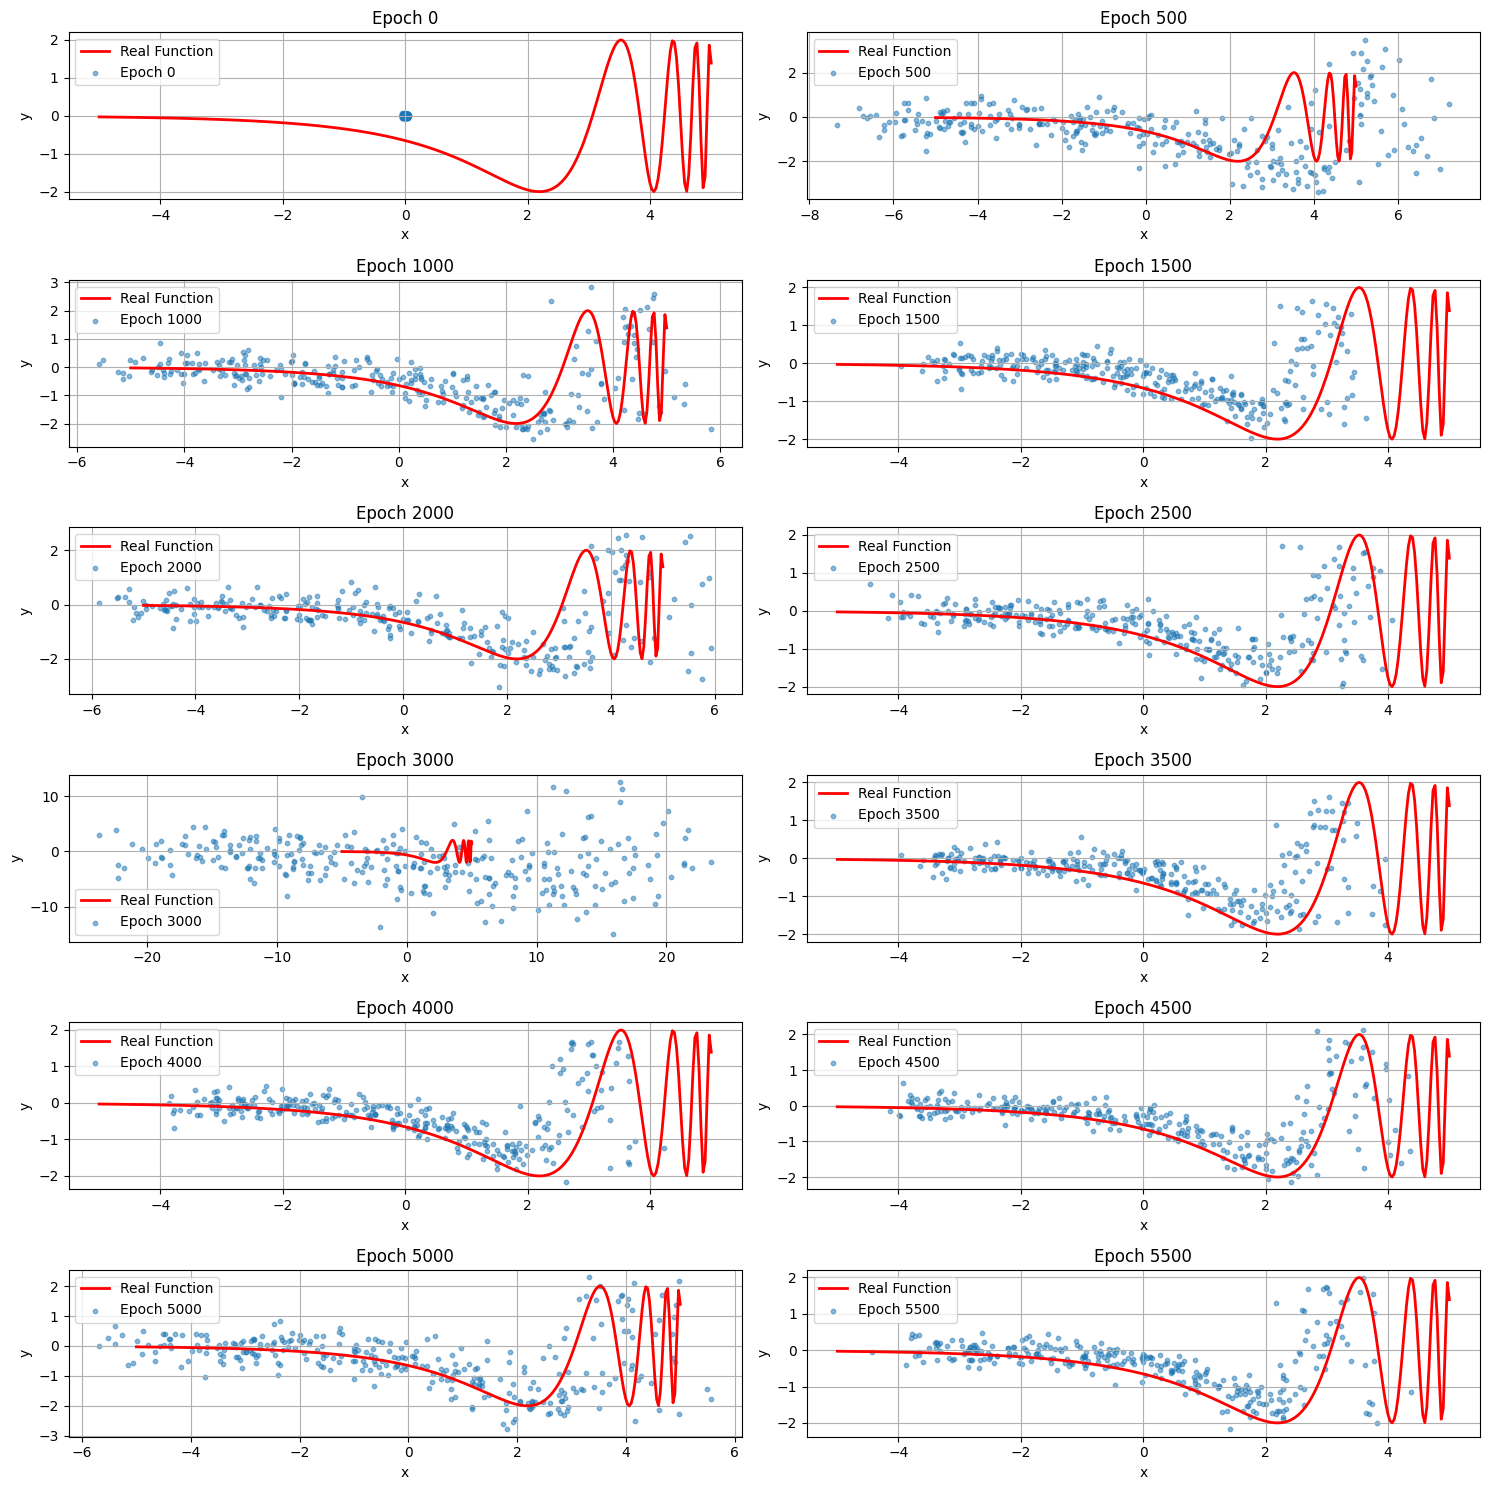

In [15]:
plt.figure(figsize=(15, 15))
n_plots = len(plot_data)
plot_idx = 1

X = np.linspace(-5, 5, N_POINTS)
y = 2 * np.sin(np.exp(X*0.5)/(X*0.5 - 3))
for epoch, data in plot_data:
    plt.subplot(PLOT_ROWS, PLOT_COLS, plot_idx)
    plt.plot(X, y, 'r-', linewidth=2, label="Real Function")
    plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.5, label=f"Epoch {epoch}")
    plt.title(f"Epoch {epoch}")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plot_idx += 1

plt.tight_layout()
plt.show()